In [1]:
import networkx as nx
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd

DATA_PATH = "data/"

# Create network
- Load dataframe with shelves
- Implode dataframe to make shelves into edgelist
- Calculate assortativity
    - Genre
    - Degrees
- Get largest sub network
- Create communities
    - Color according to genre

In [ ]:
# Create the network
def create_network(threshhold=0.2): 
    """
    Creates the network from the shelf edges. 
    If the edges have already been created, they are loaded. 
    Otherwise, they are created and stored. The edges are filtered by the threshhold. The network is returned.
    
    Args: 
        threshhold (int): The minimum number of times an edge must appear to be included in the network.
    
    Returns:
        G (networkx.Graph): The network of book edges.
    """
    # If the edges have already been created, load them
    try: 
        # Load the shelf edges
        edges = np.load(DATA_PATH + 'shelf_edges.npy', allow_pickle=True).item() # (takes about 10 minutes)
    except: 
        # Create the shelf edges and store them (this takes about 12 hours)
        shelves_df = pd.read_csv(DATA_PATH + 'shelves_df.csv')
        # Collapse into shelves
        imploded_df = shelves_df.groupby('user_id')['book_id'].apply(list).reset_index()

        # Count occurrences of each book
        book_counts = {}
        for i, shelf in tqdm(imploded_df.iterrows(), total=imploded_df.shape[0]):
            for book in shelf['book_id']:
                if book in book_counts:
                    book_counts[book] += 1
                else:
                    book_counts[book] = 1

        # Count appearances of pairs of books 
        edges = {}
        for i, shelf in tqdm(imploded_df.iterrows(), total=imploded_df.shape[0]):
            if len(shelf['book_id']) > 1:
                # Generate pairs of books 
                for i in range(len(shelf['book_id'])):
                    for j in range(i+1, len(shelf['book_id'])):
                        # Create edge
                        edge = frozenset([shelf['book_id'][i], shelf['book_id'][j]])
                        # Add edge to dictionary
                        if edge in edges:
                            edges[edge] += 1
                        else:
                            edges[edge] = 1

        # Weigh edges by the inverse of the root of the number of times each book appears 
        for edge in edges:
            edges[edge] = edges[edge] / (book_counts[list(edge)[0]] * book_counts[list(edge)[1]])**0.5
        
        # Store the edges
        np.save(DATA_PATH + 'shelf_edges.npy', edges)
    
    # Remove edges that are below the threshhold
    edges = {k: v for k, v in edges.items() if v >= threshhold}

    # Create the network 
    G = nx.Graph()
    G.add_edges_from(edges.keys())

    return G 
    

In [ ]:
# Load/Generate the network 
try:
    # Load the network
    G = nx.read_gpickle(DATA_PATH + "shelves_network.gpickle")
except: 
    # Make the network 
    G = create_network(2000)

    # Save the network
    nx.write_gpickle(G, DATA_PATH + "shelves_network.gpickle")


## Analysis 

In [2]:
# load data 
shelves_df = pd.read_csv(DATA_PATH + 'shelves_df.csv')

In [3]:

imploded_df = shelves_df.groupby('user_id')['book_id'].apply(list).reset_index()
#imploded_df

In [4]:
# Create dictionary edges and appearances 
edges = {}

# Go through shelves to get edges
for i, shelf in tqdm(imploded_df.iterrows(), total=imploded_df.shape[0]):
    if len(shelf['book_id']) > 1:
        # Generate pairs of books 
        for i in range(len(shelf['book_id'])):
            for j in range(i+1, len(shelf['book_id'])):
                # Create edge
                edge = frozenset([shelf['book_id'][i], shelf['book_id'][j]])
                # Add edge to dictionary
                if edge in edges:
                    edges[edge] += 1
                else:
                    edges[edge] = 1

len(edges)


100%|██████████| 818569/818569 [10:58:28<00:00, 20.72it/s]    


28704535

In [5]:
# Save the edges
np.save(DATA_PATH + 'shelf_edges.npy', edges)

In [40]:
# Load the shelf edges
edges = np.load(DATA_PATH + 'shelf_edges.npy', allow_pickle=True).item()

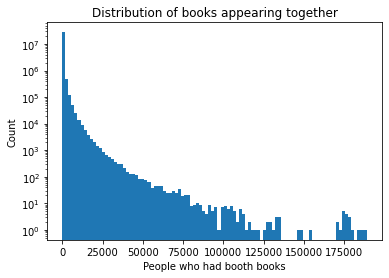

In [23]:
# Plot a histogram of the number of times each edge appears
plt.hist(edges.values(), log=True, bins=100)
# plt.xscale('log')
plt.xlabel('People who had booth books')
plt.ylabel('Count')
plt.title('Distribution of books appearing together')
plt.show()

In [13]:
sum(np.array(list(edges.values())) > 2000)

671121

In [14]:
# Remove all edges that appear less than threshhold times
threshhold = 2000
edges = {k: v for k, v in edges.items() if v >= threshhold}

In [17]:
G = nx.Graph()
G.add_edges_from(edges.keys())

In [19]:
print(G.number_of_edges(), G.number_of_nodes())

671643 5240


In [4]:
# Count occurrences of each book
book_counts = {}
for i, shelf in tqdm(imploded_df.iterrows(), total=imploded_df.shape[0]):
    for book in shelf['book_id']:
        if book in book_counts:
            book_counts[book] += 1
        else:
            book_counts[book] = 1

100%|██████████| 818569/818569 [00:43<00:00, 18900.04it/s]


Text(0.5, 1.0, 'Distribution of books appearing together')

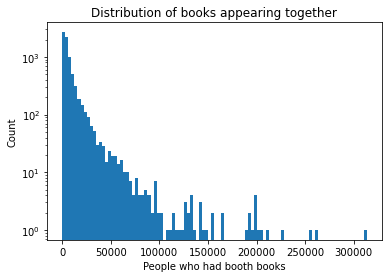

In [25]:
# Plot a histogram of the number of times each book appears
plt.hist(book_counts.values(), log=True, bins=100)
# plt.xscale('log')
plt.xlabel('People who had the book')
plt.ylabel('Count')
plt.title('Distribution of books appearing together')

In [28]:
edges.keys()

KeyboardInterrupt: 

In [31]:
for edge in tqdm(edges):
    edges[edge] = edges[edge] / (book_counts[list(edge)[0]] * book_counts[list(edge)[1]])**0.5



100%|██████████| 28704535/28704535 [00:34<00:00, 823585.16it/s]


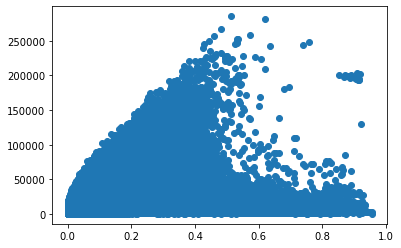

In [32]:

# Plot the edge versus the square root of the number of times each book appears
plt.scatter(edges.values(), [book_counts[list(edge)[0]]**0.5 * book_counts[list(edge)[1]]**0.5 for edge in edges.keys()])

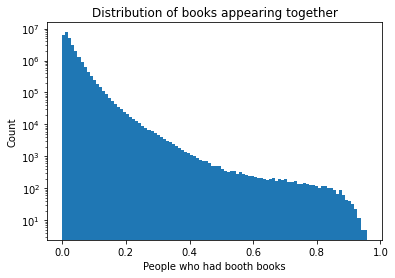

In [33]:
# Plot a histogram of the number of times each edge appears
plt.hist(edges.values(), log=True, bins=100)
# plt.xscale('log')
plt.xlabel('People who had booth books')
plt.ylabel('Count')
plt.title('Distribution of books appearing together')
plt.show()

In [37]:
# Remove all edges that appear less than threshhold times
threshhold = 0.2
edges = {k: v for k, v in edges.items() if v >= threshhold}

In [38]:
G = nx.Graph()
G.add_edges_from(edges.keys())

In [39]:
print(G.number_of_edges(), G.number_of_nodes())

42231 5083


### Decision

In [5]:
# Load the shelf edges
edges = np.load(DATA_PATH + 'shelf_edges.npy', allow_pickle=True).item()

In [6]:
# Normalize (kinda)
for edge in tqdm(edges):
    edges[edge] = edges[edge] / min(book_counts[list(edge)[0]], book_counts[list(edge)[1]])

100%|██████████| 28704535/28704535 [00:27<00:00, 1057112.01it/s]


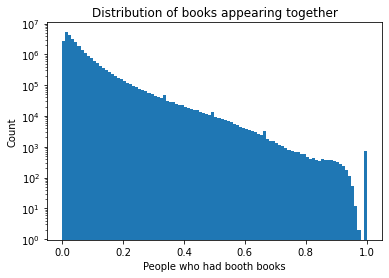

In [7]:
# Plot a histogram of the number of times each edge appears
plt.hist(edges.values(), log=True, bins=100)
# plt.xscale('log')
plt.xlabel('People who had booth books')
plt.ylabel('Count')
plt.title('Distribution of books appearing together')
plt.show()

In [64]:
# Remove all edges that appear less than threshhold times
threshhold = 0.4
edges2 = {k: v for k, v in edges.items() if v >= threshhold}

In [65]:
G = nx.Graph()
G.add_edges_from(edges2.keys())

print(G.number_of_edges(), G.number_of_nodes(), G.number_of_edges() / G.number_of_nodes())

CSS_graph_cc = sorted(nx.connected_components(G), key=len, reverse=True)
CSS_giant = G.subgraph(CSS_graph_cc[0])

In [66]:
print(G.number_of_edges(), G.number_of_nodes(), G.number_of_edges() / G.number_of_nodes())

256679 7665 33.48714938030007


In [67]:
CSS_graph_cc = sorted(nx.connected_components(G), key=len, reverse=True)
CSS_giant = G.subgraph(CSS_graph_cc[0])

In [15]:
import community

In [31]:
def louvain_communities_faster(graph):
    # Use the louvain method to find communities
    partition = community.best_partition(graph) # community function that uses Louvain-algorithm
    
    # Reformat the partitioning
    communities = {}
    for node, community_id in tqdm(partition.items()):
        communities.setdefault(community_id, []).append(node)
    
    return list(communities.values())

In [71]:
communities = louvain_communities_faster(G)

100%|██████████| 7665/7665 [00:00<00:00, 3827302.40it/s]


In [72]:
communities = louvain_communities_faster(G)

print("this is the one", len(communities))
for i in communities:
    print(len(i))

this is the one 13
1417
3248
379
422
186
1060
312
141
94
337
50
17
2


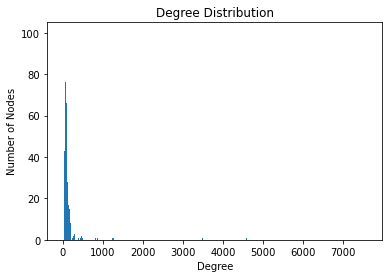

In [46]:
degree_hist = nx.degree_histogram(G)

# Plot the degree distribution
plt.bar(range(len(degree_hist)), degree_hist)
plt.xlabel('Degree')
plt.ylabel('Number of Nodes')
plt.title('Degree Distribution')
plt.show()

In [70]:
nx.write_graphml(G, DATA_PATH + 'shelves_graph_04.graphml')
# To load again 
# G = nx.read_graphml(DATA_PATH + 'shelves_graph_04.graphml')

In [73]:
# save the communities 
np.save(DATA_PATH + 'shelves_communities_04.npy', communities)

# Load the communities
communities = np.load(DATA_PATH + 'shelves_communities_04.npy', allow_pickle=True)

c:\Users\david\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


In [74]:
communities = np.load(DATA_PATH + 'shelves_communities_04.npy', allow_pickle=True)

In [75]:
for i in communities:
    print(len(i))

1417
3248
379
422
186
1060
312
141
94
337
50
17
2


In [76]:
# Load the NLP graph
edges = np.load(DATA_PATH + 'NLP_edges.npy', allow_pickle=True).item()

In [77]:
# Find the value that separates the top 256679 larges edges from the rest 
threshhold = sorted(edges.values(), reverse=True)[G.number_of_edges()]
threshhold

0.043147329596140066

In [78]:
edges2 = {k: v for k, v in edges.items() if v >= threshhold}

In [79]:
G = nx.Graph()
G.add_edges_from(edges2.keys())

print(G.number_of_edges(), G.number_of_nodes(), G.number_of_edges() / G.number_of_nodes())

CSS_graph_cc = sorted(nx.connected_components(G), key=len, reverse=True)
CSS_giant = G.subgraph(CSS_graph_cc[0])

256680 7671 33.461087211576064


In [80]:
communities = louvain_communities_faster(G)

100%|██████████| 7671/7671 [00:00<00:00, 1532630.21it/s]

this is the one 15
520
638
217
687
1416
1041
914
399
1093
180
121
113
107
153
72


In [81]:
print("this is the one", len(communities))
for i in communities:
    print(len(i))

this is the one 15
520
638
217
687
1416
1041
914
399
1093
180
121
113
107
153
72


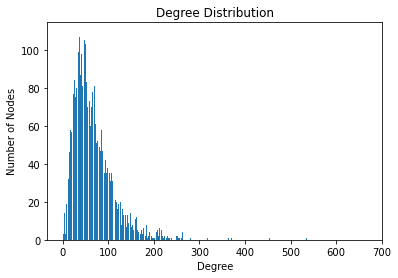

In [82]:
degree_hist = nx.degree_histogram(G)

# Plot the degree distribution
plt.bar(range(len(degree_hist)), degree_hist)
plt.xlabel('Degree')
plt.ylabel('Number of Nodes')
plt.title('Degree Distribution')
plt.show()

In [83]:
nx.write_graphml(G, DATA_PATH + 'NLP_graph_04.graphml')
np.save(DATA_PATH + 'NLP_communities_04.npy', communities)

c:\Users\david\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


In [184]:
import netwulf
import ast

In [181]:
louvain_com = communities

In [95]:
books_df = pd.read_csv(DATA_PATH + "complete_book_df.csv")

In [96]:
books_df.columns

Index(['Unnamed: 0', 'book_id', 'title', 'description', 'genres', 'tokens',
       'top_genre'],
      dtype='object')

In [173]:
def make_attributes(df):
    book_attributes = dict()
    for i, book in tqdm(df.iterrows(), total=df.shape[0]):
        node = book['book_id']
        if not node in G.nodes():
            continue
        book_attributes[node] = dict()
        top_genre = book['top_genre']
        title = book['title']
        genres = ast.literal_eval(book['genres'])

        book_attributes[node]['title'] = title
        book_attributes[node]['genres'] = genres
        book_attributes[node]['top_genre'] = top_genre
    return book_attributes


In [175]:
attribute_dict = make_attributes(books_df)

100%|██████████| 7676/7676 [00:00<00:00, 15524.30it/s]


In [176]:
print(attribute_dict)
print(len(attribute_dict))
print(len(G.nodes()))

{536: {'title': 'the hunger games', 'genres': ['young-adult', 'fiction', 'fantasy', 'science-fiction', 'romance'], 'top_genre': 'science-fiction'}, 1000: {'title': 'twilight', 'genres': ['young-adult', 'fantasy', 'romance', 'fiction', 'paranormal'], 'top_genre': 'paranormal'}, 786: {'title': 'to kill a mockingbird', 'genres': ['classics', 'fiction', 'historical-fiction', 'young-adult'], 'top_genre': 'classics'}, 858: {'title': 'the great gatsby', 'genres': ['classics', 'fiction', 'historical-fiction', 'romance'], 'top_genre': 'classics'}, 1473: {'title': 'the fault in our stars', 'genres': ['young-adult', 'romance', 'fiction', 'contemporary'], 'top_genre': 'contemporary'}, 13169: {'title': 'the hobbit', 'genres': ['fantasy', 'classics', 'fiction', 'young-adult'], 'top_genre': 'classics'}, 862: {'title': 'the catcher in the rye', 'genres': ['classics', 'fiction', 'young-adult'], 'top_genre': 'classics'}, 739: {'title': 'angels & demons', 'genres': ['fiction', 'mystery', 'thriller', 'sus

In [185]:
import matplotlib.colors as mcolors
# List of colors to use for the visualization
colors = list(mcolors.CSS4_COLORS.values())[:len(louvain_com)]

# Use netwulf to visualize the communities
def visualize_communities(graph, communities):
    # Create a dictionary that maps nodes to communities
    node_to_community = {}
    for i, community in enumerate(communities):
        for node in community:
            node_to_community[node] = i
      
    # Add a color attribute to the nodes
    for node in graph.nodes:
        # Add the community number as a node attribute
        graph.nodes[node]["color"] = colors[node_to_community[node]] 

    # Visualize the graph with netwulf
    netwulf.visualize(graph, config={"Node color": "color",
                                    'node_size': 50,
                                    'link_width': 0.1,
                                    'link_alpha': 0.01,
                                    'node_size_exponent': 0.8,
                                    'zoom': 0.6,})

In [189]:
genre_dict = {}
for node in tqdm(G.nodes):
    genre = nx.get_node_attributes(G, 'top_genre')[node]
    try:
        genre_dict[genre].append(node)
    except:
        genre_dict[genre] = [node]


100%|██████████| 7671/7671 [00:19<00:00, 384.55it/s]


In [ ]:
colors = list(mcolors.CSS4_COLORS.values())[20:len(genre_dict.keys())+20]

# Use netwulf to visualize the communities
def visualize_genres(graph, genre_dict):
    # Create a dictionary that maps nodes to communities
    node_to_genre = {}
    for i, genre in enumerate(genre_dict.keys()):
        for node in genre_dict[genre]:
            node_to_genre[node] = i
      

      
    # Add a color attribute to the nodes
    for node in graph.nodes:
        # Add the community number as a node attribute
        graph.nodes[node]["color"] = colors[node_to_genre[node]] 

    # Visualize the graph with netwulf
    netwulf.visualize(graph, config={"Node color": "color",
                                    'node_size': 50,
                                    'link_width': 0.1,
                                    'link_alpha': 0.01,
                                    'node_size_exponent': 0.8,
                                    'zoom': 0.6,})

In [186]:
visualize_communities(G, louvain_com)

In [198]:
visualize_genres(G, genre_dict)

In [177]:
nx.set_node_attributes(G, attribute_dict)

In [152]:
nw.visualize(G, config = {
    'node_size': 35,
    'link_width': 0.1,
    'link_alpha': 0.3,
    'node_size_exponent': 0.3,
    'zoom': 0.6,
})

(None, None)

In [178]:
nx.get_node_attributes(G, 'top_genre')

{536: 'science-fiction',
 1387: 'science-fiction',
 1386: 'science-fiction',
 7071: 'science-fiction',
 750: 'suspense',
 6477: 'science-fiction',
 3639: 'horror',
 17185: 'fantasy',
 7342: 'horror',
 23464: 'graphic-novels',
 17268: 'fantasy',
 1549: 'science-fiction',
 6865: 'fantasy',
 25518: 'contemporary',
 7403: 'classics',
 13111: 'science-fiction',
 2577: 'romance',
 747: 'suspense',
 19723: 'classics',
 3054: 'science-fiction',
 66826: 'suspense',
 19913: 'fantasy',
 55: 'paranormal',
 17487: 'horror',
 6397: 'romance',
 19445: 'fantasy',
 254760: 'young-adult',
 101720: 'psychology',
 13341: 'young-adult',
 12204: 'sports',
 21369: 'romance',
 175883: 'suspense',
 60151: 'science-fiction',
 16204: 'fantasy',
 69130: 'philosophy',
 22349: 'science-fiction',
 6648: 'paranormal',
 41915: 'young-adult',
 11053: 'suspense',
 3926: 'mystery',
 13995: 'romance',
 308555: 'thriller',
 17159: 'philosophy',
 48794: 'historical-fiction',
 12572: 'young-adult',
 945627: 'sports',
 97036:

In [ ]:
[938, 941, 613, 968,536]